I propose to make an NLP pipeline that will ultimately classify legal testimony into topics.

Problem:
Unreliable speech from public officials and news networks have reached a head in our nation.  News outlets, law offices, researchers, as well as others have an innate desire to be able to easily find relevant information within current, past, and future cases on the fly (immediate basis).  The purpose is to allow cross-referencing multiple testimonies and other public speech for inconsistencies and inaccuracies over time.

Solution:
Collect testimony, commentary, etc. from a target witness or person over years in the past to feed into our classifier.  The neural network will make determinations of the validity of statements in near real-time.  As one can imagine, having such a tool at your disposal during an interview can be powerful in challenging testimony.  This could broaden out to public statements made over news networks, social media, etc. to combat the misinformation propagated as of late.  Not only could AI be an effective tool in ensuring the accountability of truth to supersede all else but, we could create a subscription service to which news outlets and other researchers subscribe to have access to the neural network classifier utilizing datasets collected.  Future upgrade the subscription service could use the large datasets to run personality analyses on anyone with a public social account.  The benefit of this could target human resource prospecting applicants in hiring, negotiations between individuals/companies/foreign leaders, as well as other beneficial applications not listed here.

Data Sources and Access:
https://www.congress.gov/congressional-record  - for publicly accessible transcripts of witness testimony.  It is easy to download documents and the entire site wouldn’t need to be scraped to analyze individuals for clients.
Twitter – pulling in tweets for an individual over time can be done with a scraper in python.  
Facebook – utilize Facebook’s api to get target information
Instagram – utilize Instagram’s api to get target information
With some expansion we could build a detailed profile of a target.

Expected techniques to be utilized:
Scraping data from social media
Joining/merging data
Descriptive statistics on the imported data
Cleaning the data 
NLP - parsing the text, removing Stopwords, tokenization, frequency of words, lemmatize the data, sentence analysis, bag of words (BoW), vectorize with tf-idf, word2vec, exploratory data analysis (EDA), principal component analysis (PCA), train/test , unsupervised learning algorithm, random forest classifier, logistic regression, KNN clustering

Prediction for Largest Challenge to Project:
Acquiring the variety of datasets and performing the various cleanings and tokenizations, will likely be lengthy.  As per the instructions for the project needing to be of a start-up company level, I don’t believe I can do less and still receive a positive grade.  Since I’m on a time crunch in trying to finish this project and present within a week, I am not sure this is possible.









For this stage, we want you to build out a notebook that builds and demonstrates your data science product. Reference other scripts as needed, but be sure to include those in the same repo. This notebook should demonstrate your technical prowess as well as visualization and narrative storytelling. As such it should include all stages of your process in a clean, easy to read form.

Specifically make sure to:

    Wrangle your data. Get it into the notebook in the best form possible for your analysis and model building.
    Explore your data. Make visualizations and conduct statistical analyses to explain what’s happening with your data, why it’s interesting, and what features you intend to take advantage of for your modeling.
    Build a modeling pipeline. Your model should be build in a coherent pipeline of linked stages that is efficient and easy to implement.
    Evaluate your models. You should have built multiple models, which you should thoroughly evaluate and compare via a robust analysis of residuals and failures.
    Present and thoroughly explain your product. Describe your model in detail: why you chose it, why it works, what problem it solves, how it will run in a production like environment. What would you need to do to maintain it going forward?


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import textacy
import textacy.extract
import nltk   
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stopwords = nltk.corpus.stopwords.words('english')
import scipy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import online_lda

For this project I decided to use Congresstional testimony from the recent impeachment inquiries.

Prior to importing these files as text, attempts were made to import as pdf using a variety of pdfreaders.  However, each of these pdfreaders left numerous mistakes throughout the files.  Therefore, it was necessary to utilize Adobe's own pdf decoder to pull the text out of the datafiles.  Though not perfect, this method proved to have a much better result than before.

IMPORTING: Loading data into our pipeline

In [2]:
FionaHillraw = open('Fiona-Hill-Testimony_compressed_1.txt','r').read().replace('\n',' ')
AlexVindmanraw = open('ALEXANDER-VINDMAN_compressed.txt', 'r').read().replace('\n', ' ')
Morrisonraw = open('Morrison-Final-Version_compressed.txt', 'r').read().replace('\n', ' ')
BillTaylorraw = open('Bill-Taylor-testimony_compressed.txt', 'r').read().replace('\n', ' ')
GeorgeKentraw = open('George-Kent-Transcript_compressed_1.txt', 'r').read().replace('\n', ' ')
Holmesraw = open('Holmes-Final-Version-Redacted.txt', 'r').read().replace('\n', ' ')
Sandyraw = open('Sandy-Final-Redacted.txt', 'r').read().replace('\n', ' ')
CatherineCroftraw = open('Catherine-Croft-Testimony2.txt', 'r').read().replace('\n', ' ')
MashaYraw = open('Masha-Y-testimony_compressed_1.txt', 'r').read().replace('\n', ' ')

In [3]:
#Combining all raw testimony into one file.  This varies from the 
#test variable as seen in a future cell.
RawWit=[
open('Fiona-Hill-Testimony_compressed_1.txt','r').read(), 
open('ALEXANDER-VINDMAN_compressed.txt', 'r').read(),
open('Morrison-Final-Version_compressed.txt', 'r').read(),
open('Bill-Taylor-testimony_compressed.txt', 'r').read(),
open('George-Kent-Transcript_compressed_1.txt', 'r').read(),
open('Holmes-Final-Version-Redacted.txt', 'r').read(),
open('Sandy-Final-Redacted.txt', 'r').read(),
open('Catherine-Croft-Testimony2.txt', 'r').read(),
open('Masha-Y-testimony_compressed_1.txt', 'r').read()
]

The import was successful as seen below in the sample from FionaHillraw data.  There are still some errors in decoding that we will have to clean.

In [4]:
#Looking at Fiona's testimony for errors
FionaHillraw[2000:2500]

" a 16 senior fellow with the Brookings Institution, and, most 17 recently, as Deputy Assistant to the President and Senior 18 Director for Europe and Russia on the Nati onal Security 19 Council staff. 20 In her most recent work at the White House, Dr. Hill 21 held a unique position at the top of the executive branch's 22 policymaking process, in which she would have had access to 23 and been involved in key policy discussions, meetings, and 24 decisions on Ukraine that relate d i rectly to areas"

TRANSFORMING: Storing the order of our witness testimonies as they appear within the combined document into a witness variable.

In [5]:
witness = ['Hill', 'Yovanovitch', 'Vindman', 'Morrison', 'Taylor', 'Kent', 'Holmes', 
           'Sandy', 'Croft']

In [12]:
#Combining the various testimonies into one file
alltest = ()
alltest = str(alltest).join([FionaHillraw, AlexVindmanraw, Morrisonraw, BillTaylorraw, GeorgeKentraw, Holmesraw, 
                             Sandyraw, CatherineCroftraw, MashaYraw])

#Finding the length of our data
print(len(alltest))

2611478


CLEANING:
    We will start by making the characters lowercase and removing non-text characters.

In [13]:
def testpreptxt(FILE):
    # Perform some basic cleaning and character removal.
    
    # Make everything lower case.
    text = FILE.lower()
    
    # Remove non-text characters.
    text = text.replace(r'\.|\!|\?|\'|,*|-|\(|\)', "")
    text = re.sub(r'\d+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[''""-]', '', text)
    text = re.sub(r'[^\W\d]*$', '', text)
    text = re.sub('say', '', text)
    
    return text


#cleaning
alltestclean = testpreptxt(alltest)

In [14]:
alltestclean

"unclassified           permanent select committee on intelligence,  joint with the  committee on oversight and reform  and the  committee on foreign affairs,  u.s. house of representatives,  washington, d.c.       \tdeposition of:\tfiona hill          monday, october ,   washington, d.c.     the deposition in the above matter was held in room  hvc, capitol visitor center, commencing at : a.m.  unclassified\t present:\trepresentatives schiff, carson, swalwell, and  heck.  also present:\trepresentatives raskin, rouda, rooney,  jordan, zeldin, perry, and gaetz.                                         unclassif ied\t  appearances:   \tfor the permanent select committee on intelligence: \t \t \t \t \t \t \t \t \t \t \t \t \t   \t \t  \tfor the committee on oversight and reform: \t    unclassified\t    \tfor the commi ttee on foreign affairs: \t \t \t \t    \tfor fiona hill:   samuels. ungar  lee wolosky  boies schiller flexner llp   new york avenue, nw  washington. d.c.                uncl

Exploratory Data Analysis (EDA): creating a function for wordcloud that will take the file/s CLEAN them by filtering out stopwords and displaying the top terms.

In [15]:
#creating wordcloud function

def wordcloud(FILE): 
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=75, max_font_size=80,
                          random_state=0).generate(FILE)
    plt.imshow(wordcloud, interpolation= 'bilinear')
    plt.axis('off')
    plt.margins(x=0,y=0)
    plt.show()

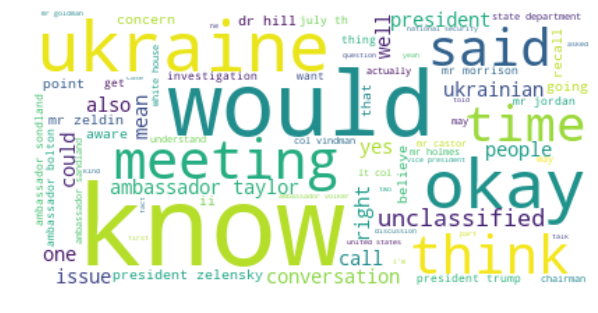

In [19]:
#creating the wordcloud from all testimony input
plt.figure(figsize=(10,10))
wordcloud(alltestclean)
#the resulting picture below represents what we can expect once we
#remove stopwords.

CLEANING/TOKENIZING: using spacy to tokenize the testimonies as well as removing STOPWORDS.  NLP.max_length had to be increased greatly to accomodate our dataset.

In [20]:
#tokenize with spacy

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
nlp = spacy.load('en_core_web_md')
nlp.max_length = 2600000
alltestnlp = nlp(alltestclean)

#find the length
print (len(alltestnlp))

#check the outcome
print (alltestnlp[300:400])

591934
for complying with the duly authorized  congressional subpoena.  dr. hill has served with distinction in and out of  government, including as national intelligence officer for  russia and eu rasi a at the national intelligence council, as a  senior fellow with the brookings institution, and, most  recently, as deputy assistant to the president and senior  director for europe and russia on the nati onal security  council staff.  in her most recent work at the white house, dr. hill  held a unique


The tokens are looking a lot easier for our machine to use.  Next is to find the vectors of each word to use within the LDA model.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = [alltestclean]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)


# summarize encoded vector
print(vector.shape)
print(type(vector))
alltestcv = (vector.toarray())
print (alltestcv[200:400])

{'unclassified': 10176, 'permanent': 7019, 'select': 8650, 'committee': 1680, 'on': 6571, 'intelligence': 4770, 'joint': 5006, 'with': 10739, 'the': 9717, 'oversight': 6813, 'and': 413, 'reform': 7947, 'foreign': 3737, 'affairs': 202, 'house': 4407, 'of': 6510, 'representatives': 8122, 'washington': 10578, 'deposition': 2448, 'fiona': 3644, 'hill': 4332, 'monday': 5911, 'october': 6501, 'in': 4568, 'above': 15, 'matter': 5651, 'was': 10576, 'held': 4276, 'room': 8361, 'hvc': 4442, 'capitol': 1265, 'visitor': 10497, 'center': 1346, 'commencing': 1658, 'at': 705, 'present': 7370, 'schiff': 8550, 'carson': 1293, 'swalwell': 9499, 'heck': 4269, 'also': 342, 'raskin': 7750, 'rouda': 8380, 'rooney': 8363, 'jordan': 5015, 'zeldin': 10888, 'perry': 7033, 'gaetz': 3894, 'unclassif': 10172, 'ied': 4467, 'appearances': 509, 'for': 3728, 'commi': 1670, 'ttee': 10053, 'samuels': 8493, 'ungar': 10248, 'lee': 5298, 'wolosky': 10757, 'boies': 1035, 'schiller': 8551, 'flexner': 3683, 'llp': 5441, 'new'


(1, 10907)
<class 'scipy.sparse.csr.csr_matrix'>
[]


EXPERIMENTING WITH VARIOUS VECTORIZERS:

TDIDF VECTORIZING: I have chosen the tdidf vectorizer since each vector provides greater context for each token thereby allowing a smarter classifier, when compared to a count vectorizer.

In [23]:
alltestnlpsent = [sent.text for sent in alltestnlp.sents]
alltestnlpsent

['unclassified           permanent select committee on intelligence,  joint with the  committee on oversight and reform  and the  committee on foreign affairs,  u.s. house of representatives,  washington, d.c.       \t',
 'deposition of:\tfiona hill          ',
 'monday, october ,   washington, d.c.     ',
 'the deposition in the above matter was held in room  hvc, capitol visitor center, commencing at : a.m.  unclassified\t ',
 'present:\t',
 'representatives schiff, carson, swalwell, and  ',
 'heck.  ',
 'also present:\t',
 'representatives raskin, rouda, rooney,  jordan, zeldin, perry, and gaetz.                                         ',
 'unclassif ied\t  ',
 'appearances:   \tfor the permanent select committee on intelligence: \t \t \t \t \t \t \t \t \t \t \t \t \t   \t \t  \tfor the committee on oversight and reform: \t    ',
 'unclassified\t    \tfor the commi ttee on foreign affairs: \t \t \t \t    \tfor fiona hill:   samuels.',
 'ungar  ',
 'lee wolosky  ',
 'boies schiller f

In [25]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = STOPWORDS,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)

FITTING: prepare the sentence nlp tokenized data set and fit it to the TFIDF vectorizer followed by fitting to our LDA model.

In [26]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(alltestnlpsent)
print(dtm_tfidf.shape)

C:\Users\test\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)
C:\Users\test\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'mustn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(49500, 2209)


In [27]:
#fit the LDA to the tfidf data set
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=42)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

VISUALIZE THE RESULTS:  Utilizing pyLDAvis interactive graphic, we can learn of the unsupervised machine topic creations.  

In [28]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

c:\program files\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.080520 -0.076464       1        1  30.317216
2     -0.110316 -0.098839       2        1  20.656777
4     -0.038839 -0.156816       3        1  20.656703
3     -0.142887  0.284966       4        1  15.607674
1      0.372561  0.047153       5        1  12.761629, topic_info=     Category         Freq          Term        Total  loglift  logprob
1308  Default  2087.000000          okay  2087.000000  30.0000  30.0000
2197  Default  1046.000000           yes  1046.000000  29.0000  29.0000
306   Default   745.000000      chairman   745.000000  28.0000  28.0000
80    Default   787.000000    ambassador   787.000000  27.0000  27.0000
2062  Default   611.000000  unclassified   611.000000  26.0000  26.0000
...       ...          ...           ...          ...      ...      ...
1716   Topic5    98.274202          said   388.190376   0.6850  -4.4859
464    Topic5    51.982082       counsel   110.243013   1.3069  -5.1227
2140   Topic5    74.125488          well   288.445448   0.7000  -4.7679
190    Topic5    51.991358          back   227.911951   0.5808  -5.1226
1857   Topic5    45.717457         staff   141.369945   0.9298  -5.2512

[304 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
9         2  0.980097    accurate
57        2  0.965985       ahead
63        4  0.977583        alex
80        1  0.001269  ambassador
80        3  0.997635  ambassador
...     ...       ...         ...
2205      1  0.996820      zeldin
2206      1  0.793569    zelensky
2206      2  0.104707    zelensky
2206      3  0.088174    zelensky
2206      4  0.011022    zelensky

[502 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

In [29]:
X, _ = make_multilabel_classification(random_state=42)
lda_tfidf = LatentDirichletAllocation(n_components=3, random_state=42, n_jobs=-1, max_iter=100)
lda_tfidf.fit(X)
lda_tfidf2 = lda_tfidf.transform(X[-2:])
print(lda_tfidf2)

[[0.40311419 0.40904211 0.1878437 ]
 [0.72396333 0.06125923 0.21477744]]


NEW AND IMPROVED VERSION BETA 0.2 =================================================================================================

In [30]:
import pandas as pd
import re, nltk, spacy, gensim# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

c:\program files\python37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [31]:
df = RawWit

Cleaning and transforming the data:

In [32]:
# Cleaning the data
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in df]# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]

In [33]:
#parsing function removing punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
        deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['unclassified', 'permanent', 'select', 'committee', 'on', 'intelligence', 'joint', 'with', 'the', 'committee', 'on', 'oversight', 'and', 'reform', 'and', 'the', 'committee', 'on', 'foreign', 'affairs', 'house', 'of', 'representatives', 'washington', 'deposition', 'of', 'fiona', 'hill', 'monday', 'october', 'washington', 'the', 'deposition', 'in', 'the', 'above', 'matter', 'was', 'held', 'in', 'room', 'hvc', 'capitol', 'visitor', 'center', 'commencing', 'at', 'unclassified', 'present', 'representatives', 'schiff', 'carson', 'swalwell', 'and', 'heck', 'also', 'present', 'representatives', 'raskin', 'rouda', 'rooney', 'jordan', 'zeldin', 'perry', 'and', 'gaetz', 'unclassif', 'ied', 'appearances', 'for', 'the', 'permanent', 'select', 'committee', 'on', 'intelligence', 'for', 'the', 'committee', 'on', 'oversight', 'and', 'reform', 'unclassified', 'for', 'the', 'commi', 'ttee', 'on', 'foreign', 'affairs', 'for', 'fiona', 'hill', 'samuels', 'ungar', 'lee', 'wolosky', 'boies', 'schiller', 'f

In [34]:
#lemmatization function using nlp keeping nouns, adjs, verbs, advs in sentences
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

LEMMATIZATION: Below is where we initiate the lemmatization function and look at the results.

In [35]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['committee intelligence joint committee oversight reform committee deposition deposition matter hold room visitor center commence representative present representative appearance committee intelligence reform affair unclassifie chairman committee come order morning house committee intelligence oversight committee conduct investigation part impeachment inquiry conduct part light attempt direct witness cooperate inquiry committee choice compel appearance today thank comply authorize subpoena serve distinction government include intelligence officer fellow institution assistant president director staff work hold position top branch policymake process access involve policy discussion meeting decision relate area investigation committee unclassifie leave position day president call look hear testimony today range issue ti on investigate occur leadup call assessment evidence uncover leave include call record documentary record come light effort call announce investigation area ask pursue bi

The resulting text has removed punctuation and looks much cleaner

In [36]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=9,  # minimum reqd occurences of a word 
                             stop_words='english', # remove stop words
                             lowercase=False,    # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                             max_features=500 # max number of uniq words    
                            )
                             
data_vectorized = vectorizer.fit_transform(data_lemmatized)
print(data_vectorized)

  (0, 107)	6
  (0, 212)	5
  (0, 193)	18
  (0, 29)	20
  (0, 138)	18
  (0, 64)	11
  (0, 61)	12
  (0, 52)	32
  (0, 249)	29
  (0, 203)	25
  (0, 134)	12
  (0, 60)	8
  (0, 66)	9
  (0, 36)	15
  (0, 224)	12
  (0, 5)	12
  (0, 185)	40
  (0, 252)	33
  (0, 97)	38
  (0, 27)	5
  (0, 188)	56
  (0, 227)	140
  (0, 110)	39
  (0, 48)	24
  (0, 1)	5
  :	:
  (8, 16)	1
  (8, 100)	10
  (8, 94)	10
  (8, 105)	5
  (8, 46)	9
  (8, 93)	13
  (8, 135)	3
  (8, 148)	12
  (8, 40)	21
  (8, 32)	16
  (8, 6)	5
  (8, 11)	3
  (8, 161)	4
  (8, 189)	2
  (8, 41)	1
  (8, 30)	1
  (8, 245)	1
  (8, 199)	4
  (8, 91)	7
  (8, 125)	2
  (8, 63)	28
  (8, 180)	8
  (8, 149)	7
  (8, 101)	5
  (8, 42)	21


Getting the LDA model ready

In [37]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=4,               # Number of topics
                                      max_iter=30,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=500,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=500, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=4, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [38]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -287419.8614980587
Perplexity:  138.14779630286571
{'batch_size': 500,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 30,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [39]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 
                 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=10,
                learning_method='online', learning_offset=50.,random_state=42)  
                                

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)


# Do the Grid Search
model.fit(data_vectorized)


GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=200,
             mean_change_tol=0.001, n_components=5, n_jobs=1,
                                           perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
             iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 
                   'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

C:\Users\test\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method=None,
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=200,
                                                 mean_change_tol=0.001,
                                                 n_components=5, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_

 Perplexity is a statistical measure of how well a probability model predicts a sample.

The best parameters are listed below after having the machine experiment.

In [40]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -100061.40280085184
Model Perplexity:  143.8813120762175


DTM Document Term Matrix creation:

In [41]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)


# column names
topicnames = ['Topic' + str(i) for i in 
              range(best_lda_model.n_components)]


# index names
docnames = ['Doc' + str(i) for i in range(len(data))]


# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)


# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic 


# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)


# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

Topic-Keyword matrix

In [42]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)


# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames


# View
df_topic_keywords.head()

access   account    action   address  administration   advisor  \
Topic0  0.624192  0.479005  0.493013  0.397425        1.087996  0.483770   
Topic1  0.394689  0.427111  0.463045  0.309308        0.373502  0.350716   
Topic2  0.424071  0.406350  0.508909  0.335309        0.504317  0.439032   
Topic3  0.545351  0.544089  0.546490  0.398363        0.727632  0.430328   
Topic4  0.528357  0.399677  0.362184  0.360226        0.581502  0.364355   

          affair    agency  announce    answer  ...  violation   visitor  \
Topic0  0.454216  0.504685  0.482379  1.051251  ...   0.347321  0.391065   
Topic1  0.316237  0.399782  0.372147  0.616749  ...   0.381993  0.371917   
Topic2  0.406598  0.470496  0.397577  0.854908  ...   0.350352  0.291818   
Topic3  0.495513  0.546421  0.508688  1.116641  ...   0.425470  0.389618   
Topic4  0.399569  0.517517  0.339160  1.074111  ...   0.396353  0.328623   

            wait      want       way      week   witness      work     write  \
Topic0  0.594304  3.426989  1.901995  1.297588  0.841233  1.841638  0.991343   
Topic1  0.339843  1.110136  0.703458  0.589756  0.459124  0.703715  0.496831   
Topic2  0.348306  1.435976  0.761476  0.602896  0.503419  0.599844  0.444448   
Topic3  0.505207  2.120851  1.738957  0.824198  0.827203  2.097895  0.671598   
Topic4  0.377524  2.320656  0.665905  0.717192  0.445564  1.134529  0.533479   

            year  
Topic0  0.773180  
Topic1  0.848435  
Topic2  0.697663  
Topic3  0.832019  
Topic4  0.587613  

[5 rows x 254 columns]

In [46]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)


# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

Word 0 Word 1        Word 2        Word 3        Word 4     Word 5  \
Topic 0  meeting    say          know         think          tell       want   
Topic 1      say   know          time  conversation         think  president   
Topic 2      say  think  conversation          time     president    meeting   
Topic 3     know    say          time         think       meeting  president   
Topic 4      say   know     president          want  conversation      think   
Topic 5  meeting   know           say          time  conversation      think   
Topic 6     know    say         think       meeting          time       mean   
Topic 7      say   know         think  conversation      question    meeting   
Topic 8      say   know  conversation         think     president    meeting   
Topic 9      say   know  conversation       meeting          time  president   

            Word 6        Word 7        Word 8     Word 9   Word 10   Word 11  \
Topic 0  president  conversation          time       come  chairman      talk   
Topic 1    meeting         issue          come       meet       ask      want   
Topic 2       make          want          know       tell   concern       ask   
Topic 3   chairman      question  conversation     people      make      want   
Topic 4       time       meeting       concern     relate    recall      tell   
Topic 5  president           ask          want     recall  chairman      come   
Topic 6       want     president          talk     people       ask  question   
Topic 7       time          make         point  president      want      come   
Topic 8       time          want          make     recall  chairman      tell   
Topic 9      think           ask      chairman       want      come    recall   

               Word 12   Word 13     Word 14    Word 15     Word 16   Word 17  \
Topic 0       question    people     believe    concern       issue     thing   
Topic 1           make    recall    chairman        try     believe      tell   
Topic 2           talk    recall       point      issue    question   believe   
Topic 3            ask      work  understand       tell        talk      come   
Topic 4       question  chairman        make        ask     believe   provide   
Topic 5           make  question       issue       talk     concern     point   
Topic 6          point       try        make       come     concern      tell   
Topic 7  investigation      talk         ask  statement        mean  official   
Topic 8            ask   concern        come   question  assistance       day   
Topic 9           make      tell    question      issue        talk   believe   

               Word 18        Word 19  
Topic 0            ask  investigation  
Topic 1  investigation       question  
Topic 2       chairman  investigation  
Topic 3            try            way  
Topic 4     understand          issue  
Topic 5  investigation           meet  
Topic 6       chairman          issue  
Topic 7         people           tell  
Topic 8          issue        believe  
Topic 9        concern  investigation

FUNCTION: predict_topic(text)

In [47]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
    
    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
    
    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores

# Predict the topic
mytext = ['interfering in the election']
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['say', 'know', 'think', 'tell', 'want', 'president', 'conversation', 'time', 'come', 'chairman', 'talk', 'question', 'people']
investigation


In [49]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components

lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.    0.    0.    0.    0.    0.    0.15  0.    0.    0.99]
 [-0.   -0.   -0.   -0.   -0.   -0.    0.99 -0.   -0.   -0.15]]
Perc of Variance Explained: 
 [0.35 0.65]


Percent of variance explained utilizing SVD is 35% and 65%

Text(0.5, 1.0, 'Segregation of Topic Clusters')

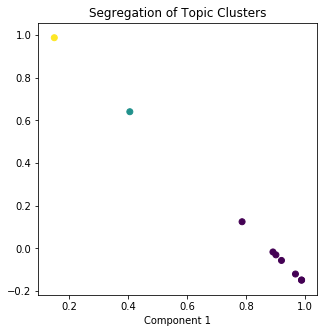

In [50]:
# Plot
plt.figure(figsize=(5,5))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

I chose LDA due to its nature of predicting topics input into it from potentially unknown sources or topics.  This proves to be robust when dealing with unknown docs.

Fact Generator

In [51]:
def topicinfo(sourcefile, topic):
    statements = textacy.extract.semistructured_statements(sourcefile, topic)
    # Print the results
    print("Here are the things I know about", topic,":")
    for statement in statements:
        subject, verb, fact = statement
        print(f" - {fact}")

In [ ]:
topicinfo(alltestclean, 'zelensky')